# Human vs. AI text classification
## Introduction and  Problem Definition
This notebook explores how human and AI generated text differ and how to best classify text samples using a fine-tuned RoBERTa model. This problem is a binary classification problem. In this notbook, a simple TF-IDF base classification baseline model will be compared to a more sophisticated transformer based model, RoBERTa.

## Business Context
In recent times, it is getting increasingly difficult to judge, whether a text has been written by a human or by AI. This is important for eveyday use, when reading news or social media posts, but also for teachers in schools, which might have to grade many AI-written texts. It might be a bit ironic to use AI to detect AI, maybe what makes AI so good at copying human texts may also help to identify AI texts.

## Dataset
Two datasets have been considered:
1. https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text/code
2. https://huggingface.co/datasets/NicolaiSivesind/human-vs-machine

The first dataset consists of ~500000 essays, both created by AI and humans. However, it is unclear, what the sources are, especially the AI generated part. Also, I assume, based on the description, that the samples in the dataset are not from the same domain or writing style, e.g. a formal letter vs. prose vs. a technical description. This makes it difficult to tell, if there are any systematic differences in this dataset.

To make my life easier, I am using the second dataset. This dataset consists of roughly 150'000 Wikipedia intros, written by humans. For each intro title, a text intro has been generated using GPT-3. This ensures, that the text domains match as closely as possible and the writing styles are similar, i.e. factual, encyclopedic writing style.

## Preliminary checks
Check what platform I am using and if CUDA is available

In [1]:
import os
from dotenv import load_dotenv
import platform
import sys
import torch

print(f"Python version: {sys.version.split()[0]}")
print(f"Platform: {platform.platform()}")
print(f"PyTorch version: {torch.__version__}")

cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

if cuda_available:
    device_name = torch.cuda.get_device_name(0)
    cuda_version = torch.version.cuda
    cudnn_version = torch.backends.cudnn.version()
    print(f"GPU: {device_name}")
    print(f"CUDA version: {cuda_version}")
    print(f"cuDNN version: {cudnn_version}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No GPU detected — running on CPU only.")

x = torch.randn(10000, 10000).to('cuda')
torch.cuda.synchronize()
print(f"Matrix norm: {x.norm().item()}")


load_dotenv()

Python version: 3.10.12
Platform: Linux-6.8.0-87-generic-x86_64-with-glibc2.35
PyTorch version: 2.9.0+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA version: 12.8
cuDNN version: 91002
GPU memory: 8.30 GB
Matrix norm: 10000.3916015625


True

# Import dataset and perform Exploratory Data Analysis

In [2]:
import pandas as pd

df = pd.read_csv('../data/wiki-labeled.csv')

In [3]:
print(df.head())
print(df['label'].value_counts(normalize=True).mul(100).round(2))
print(df.groupby('label')['word_count'].describe())

           title  label                                               text  \
0   James Scobie      0  James Scobie (29 November 1826 – 7 October 185...   
1   James Scobie      1  James Scobie (29 November 1826 – 7 October 189...   
2   Dagliç sheep      0  The Dagliç is a breed of sheep found primarily...   
3   Dagliç sheep      1  The Dagliç is a breed of sheep that is found i...   
4  Hamdard India      0  Hamdard Laboratories (India), is a Unani pharm...   

   word_count  
0         175  
1         242  
2         152  
3          33  
4         160  
label
0    50.0
1    50.0
Name: proportion, dtype: float64
          count        mean        std    min    25%    50%    75%    max
label                                                                    
0      150000.0  196.005113  41.444268  150.0  164.0  184.0  216.0  350.0
1      150000.0  129.469147  57.040399    7.0   86.0  122.0  170.0  278.0


The original dataset has 4 columns:
* **title**: describes the wikipedia article title
* **label**: 0 is human generated, 1 is AI generated
* **text**: actual wikipedia or generated intro text
* **word_count**: Number of words in text

In addition to these columns, additional features are added for better understanding of the data
* **char_count**: Number of characters in text
* **avg_word_lenght**: Average length of words in text
* **unique_word_ratio**: "Richness" of vocabulary. Maybe AI is more creative when using words than humans

In [4]:
# Add addtional columns
df['char_count'] = df['text'].str.len()
df['avg_word_length'] = df['char_count'] / df['word_count']
df['unique_word_ratio'] = df['text'].apply(
    lambda x: len(set(x.lower().split())) / len(x.split())
)

import nltk
nltk.download('punkt')

df['sent_count'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))
df['avg_sent_length'] = df['word_count'] / df['sent_count']
df.head()


[nltk_data] Downloading package punkt to /home/funariu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,title,label,text,word_count,char_count,avg_word_length,unique_word_ratio,sent_count,avg_sent_length
0,James Scobie,0,James Scobie (29 November 1826 – 7 October 185...,175,994,5.680000,0.657143,10,17.500000
1,James Scobie,1,James Scobie (29 November 1826 – 7 October 189...,242,1377,5.690083,0.637860,11,22.000000
2,Dagliç sheep,0,The Dagliç is a breed of sheep found primarily...,152,782,5.144737,0.618056,11,13.818182
3,Dagliç sheep,1,The Dagliç is a breed of sheep that is found i...,33,175,5.303030,0.727273,2,16.500000
4,Hamdard India,0,"Hamdard Laboratories (India), is a Unani pharm...",160,1039,6.493750,0.650000,10,16.000000


In [5]:
stats = df.groupby('label')[['char_count','word_count','avg_word_length', 'unique_word_ratio', 'sent_count', 'avg_sent_length']].describe().round(2)
print(stats)

      char_count                                                          \
           count     mean     std    min     25%     50%     75%     max   
label                                                                      
0       150000.0  1202.70  272.73  426.0  1003.0  1130.0  1331.0  4141.0   
1       150000.0   787.88  352.43   35.0   517.0   740.0  1041.0  2038.0   

      word_count          ... sent_count       avg_sent_length                \
           count    mean  ...        75%   max           count   mean    std   
label                     ...                                                  
0       150000.0  196.01  ...       10.0  97.0        150000.0  24.22  15.41   
1       150000.0  129.47  ...       10.0  24.0        150000.0  17.45   4.27   

                                         
        min    25%    50%    75%    max  
label                                    
0      2.57  18.90  21.86  25.57  349.0  
1      2.36  15.09  17.00  19.25  184.0  

[2 rows

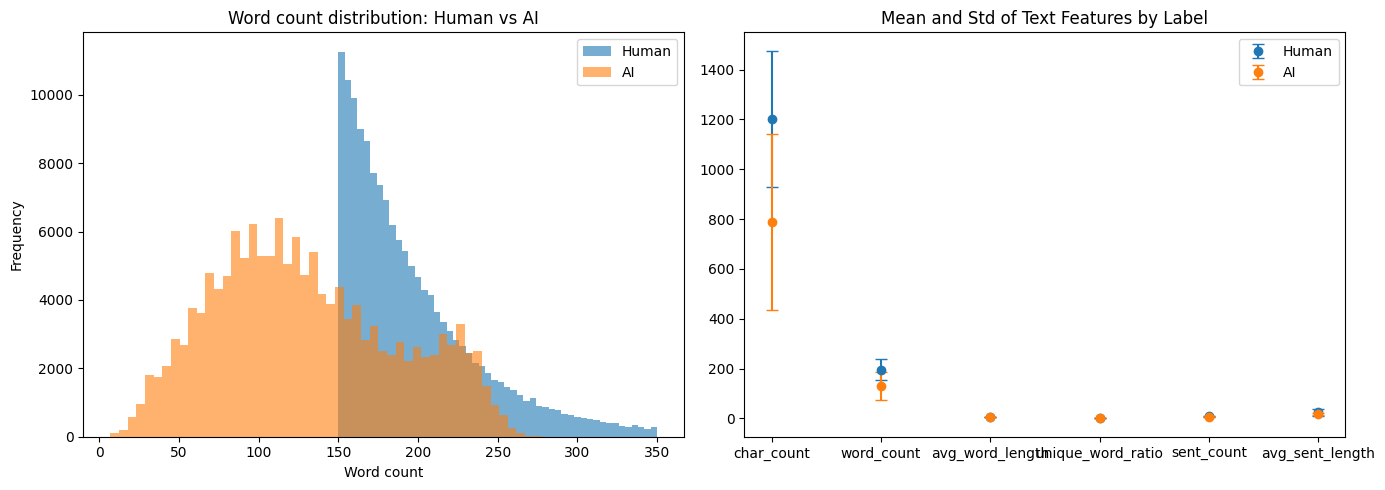

In [6]:

import matplotlib.pyplot as plt


means = stats.xs('mean', level=1, axis=1)
stds = stats.xs('std', level=1, axis=1)
label_names = {0: 'Human', 1: 'AI'}
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.hist(df.loc[df.label==0, 'word_count'], bins=50, alpha=0.6, label='Human')
plt.hist(df.loc[df.label==1, 'word_count'], bins=50, alpha=0.6, label='AI')
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.legend()
plt.title("Word count distribution: Human vs AI")
plt.subplot(122)
for label in means.index:
    plt.errorbar(
        means.columns, 
        means.loc[label], 
        yerr=stds.loc[label], 
        capsize=4, 
        marker='o', 
        linestyle='', 
        label=label_names.get(label, str(label)) 
    )
plt.legend()
plt.title("Mean and Std of Text Features by Label")
plt.tight_layout()
plt.show()

The dataset is perfectly balanced, which should be obvious given that for each human text, there is a corresponding AI generated text. We can also see that both human and AI texts have similar `avg_word_length` and `unique_word_ratio`, as well as `sent_count` and `avg_sent_length`. There are slightly more words in the human written text (`word_count` 196 vs 129 on average) but much more characters per text (`char_count`). With an almost identical average word length, this difference might come from different use in punctuation, or simply from the fact, that human texts tend to be longer, which can be seen in the histogram.

To rule out differences in punctuation, spaces and punctuations are counted and compared.

In [7]:
# See differences in punctuation and spaces, use new df, I don't want this data in original one
df2 = df[['label']].copy()
df2['punct_count'] = df['text'].str.count(r'[^\w\s]') 
df2['space_count'] = df['text'].str.count(' ')

# Relative amount of puntuation and spaces
df2['punct_ratio'] = df2['punct_count'] / df['char_count']
df2['space_ratio'] = df2['space_count'] / df['char_count']
df2[['label', 'punct_ratio', 'space_ratio']].groupby('label').mean()

,punct_ratio,space_ratio
label,,
0,0.028500,0.162947
1,0.028973,0.163576


When looking at the relative amount of punctuation and spaces, they are nearly identical between human and AI written texts. So the biggest difference is the length of the texts. In the histogram above, it can be seen, that human texts are longer on average and there are almost no texts shorter than 150 words. The AI written texts are shorter in general and most texts are around 100 words.

## Implications of word count difference on a classification model
The difference in word count could lead to a model relying simply on the number of words. Basically, a model could learn `if word_count > t, then Human, else AI` and would already be able to classify a good amount of text correctly.

## Term frequency and word cloud
In addition to character stats, I want to examine the actual words used in both human and AI texts. Maybe there is also a clear difference in words used, which a model might exploit.


Top 15 words for Human:
['born', 'new', 'american', 'university', 'known', 'school', 'time', 'years', 'early', 'world', 'later', 'city', 'united', 'film', 'year']

Top 15 words for AI:
['born', 'university', 'american', 'including', 'new', 'known', 'album', 'served', 'film', 'world', 'united', 'released', 'city', 'work', 'used']


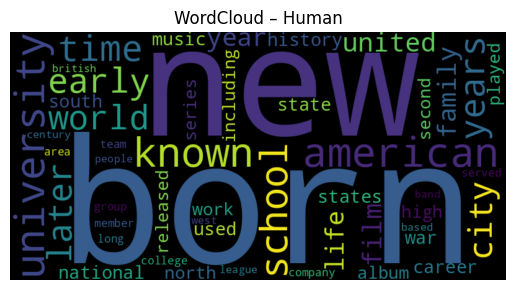

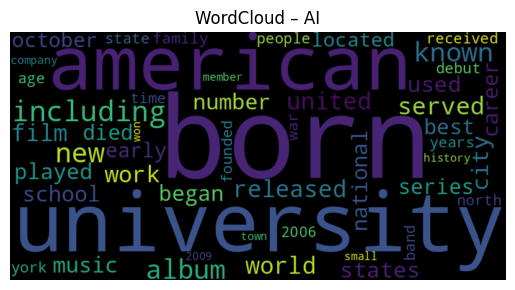

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# Calculate word frequencies for each class using a CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=50)
word_freqs = {}
n = 15 # Only print top 15 words

for lbl, name in [(0, "Human"), (1, "AI")]:
    X = vectorizer.fit_transform(df.loc[df.label==lbl, 'text'])
    word_freqs[name] = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))
    print(f"\nTop {n} words for {name}:")
    top_words = sorted(word_freqs[name].items(), key=lambda kv: kv[1], reverse=True)
    print([word for word, freq in top_words[:n]])

for lbl, name in [(0, "Human"), (1, "AI")]:
    wc = WordCloud(width=800, height=400)
    wc.generate_from_frequencies(word_freqs[name])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud – {name}")
    plt.show()


Not surprisingly, the words used do not match perfectly, but do also not differ to much. This makes sense, as the texts are about the same topics, so the words used should somewhat be similar.

# Baseline Models
For a first baseline model, the dataset will be used as as is, **i.e. without adressing the imbalance in word count**. A straight forward approach to this binary classification problem would be to use a TF-IDF + Logistic Regression model. If the difference in words used is an indicator for text source, this model should perform reasonably well.

As the dataset is perfectly balanced, `accuracy` can be used for evaluation, also because there is no importance between false positives and false negatives, as would be the case for spam detection. However, all metrics are logged for completeness.

## Splitting the data
As the data comes in pairs (each title twice, once written by human and once by AI), it must be ensured, that the pairs stay in one set and are not split into training and test. Splitting the pairs might lead to data leakage, as the texts for each title may contain similar words. Therefore, `GroupShuffleSplit` is used with `title` as group.

In [9]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score

X = df["text"].values
y = df["label"].values
groups = df["title"].values

gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
df_train = df.iloc[train_idx].copy()


In [10]:
def make_pipe():
    return Pipeline([
        ("tfidf", TfidfVectorizer(
            lowercase=True, stop_words="english",
            ngram_range=(1,2), min_df=5, max_df=0.9, strip_accents="unicode"
        )),
        ("lr", LogisticRegression(max_iter=2000, solver="lbfgs"))
    ])

def evaluate(name, pipe, X_tr, y_tr, X_te, y_te):
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)
    print(f"\n=== {name} ===")
    print(classification_report(y_te, y_pred, digits=3))
    return pipe

In [11]:
pipe = make_pipe()
pipe = evaluate("Original dataset", pipe, X_train, y_train, X_test, y_test)


=== Original dataset ===
              precision    recall  f1-score   support

           0      0.944     0.952     0.948     30000
           1      0.952     0.943     0.948     30000

    accuracy                          0.948     60000
   macro avg      0.948     0.948     0.948     60000
weighted avg      0.948     0.948     0.948     60000



## Baseline performance - not corrected for word count
The first baseline model achieves an accuracy and F1 score of 0.948, which is pretty good for such a simple model. This performance could come from the model relying on the differences in word count between humand and AI written text, as discussed above. A baseline is implemented, which only relies on word count using only a logistic regression on word count.

In [12]:

# Create word count only data from original data
X_train_wc = df.iloc[train_idx][['word_count']].values
X_test_wc  = df.iloc[test_idx][['word_count']].values
y_train_wc = y_train
y_test_wc  = y_test

lr_wc = LogisticRegression(max_iter=1000)
lr_wc.fit(X_train_wc, y_train_wc)
y_pred_wc = lr_wc.predict(X_test_wc)


print("F1 word count only:", f1_score(y_test_wc, y_pred_wc))

F1 word count only: 0.7376224156692056


## Correcting for word count differences
Word-count-only Logistic Regression achieves an F1 score of ~0.738, whereas TF-IDF + Logistic Regression achieves ~0.948. This means, the TF-IDF + Logistic Regression improves the simple word count base model by roughly 20%. Put differently, 3/4 of the time it is sufficient to only look at the number of words to correctly classify the texts. However, reliying on word count will generalize very poorly. To ensure, that word count does not affect the results, the dataset will be corrected, so that both human and AI written texts have similar word counts. The texts will be truncated pairwise to the shorer length. 

A third baseline model is trained on this truncated dataset.

In [13]:
import re

# USe regex to count words
WORD = re.compile(r"\w+(?:'\w+)?|[^\w\s]")
def wc(t):
    return len(WORD.findall(t))
# Calculate truncation cap, i.e. where to cut texts so that both human and AI versions have same length
cap = (df.groupby("title")["text"]
         .apply(lambda s: min(wc(s.iloc[0]), wc(s.iloc[1]))).to_dict())

def trunc(text, n):
    toks = WORD.findall(text)
    return " ".join(toks[:n])

# Create a new dataframe with truncated texts
df_trunc = df[['title','label', 'text', 'word_count']].copy(deep=True)
df_trunc["text_trunc"] = df_trunc.apply(lambda r: trunc(r["text"], cap[r["title"]]), axis=1)
df_trunc["word_count_trunc"] = df_trunc["text_trunc"].apply(lambda t: len(t.split()))


In [14]:
df_trunc.head()


,title,label,text,word_count,text_trunc,word_count_trunc
0,James Scobie,0,James Scobie (29 November 1826 – 7 October 185...,175,James Scobie ( 29 November 1826 – 7 October 18...,208
1,James Scobie,1,James Scobie (29 November 1826 – 7 October 189...,242,James Scobie ( 29 November 1826 – 7 October 18...,208
2,Dagliç sheep,0,The Dagliç is a breed of sheep found primarily...,152,The Dagliç is a breed of sheep found primarily...,38
3,Dagliç sheep,1,The Dagliç is a breed of sheep that is found i...,33,The Dagliç is a breed of sheep that is found i...,38
4,Hamdard India,0,"Hamdard Laboratories (India), is a Unani pharm...",160,"Hamdard Laboratories ( India ) , is a Unani ph...",152


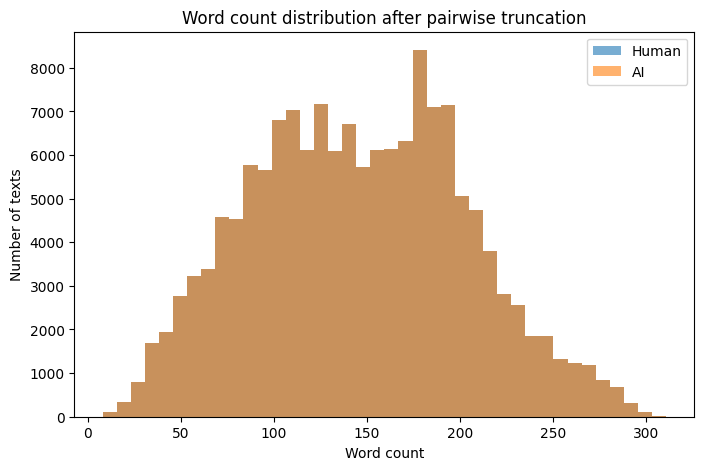

In [15]:
plt.figure(figsize=(8,5))
plt.hist(df_trunc[df.label==0]["word_count_trunc"], bins=40, alpha=0.6, label="Human")
plt.hist(df_trunc[df.label==1]["word_count_trunc"], bins=40, alpha=0.6, label="AI")
plt.xlabel("Word count")
plt.ylabel("Number of texts")
plt.title("Word count distribution after pairwise truncation")
plt.legend()
plt.show()

It can be seen both in the dataset itself and the word count distribution, that the word counts of human and AI texts now match perfectly. There is no way to tell the text source by simply looking at the word count. To be sure, both base line models, Logistic Regression on word count and TF-IDF + Logistic Regression are evaluated on the new, truncated dataset.

In [16]:
X_trunc = df_trunc["text_trunc"].values
y_trunc = df_trunc["label"].values
groups = df_trunc["title"].values  

# Reinstatiate Splitter, to be on the safe side
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx_trunc, test_idx_trunc = next(gss.split(X_trunc, y_trunc, groups))

# Creat new train/test splits with truncated data
X_train_trunc, X_test_trunc = X_trunc[train_idx_trunc], X_trunc[test_idx_trunc]
y_train_trunc, y_test_trunc = y_trunc[train_idx_trunc], y_trunc[test_idx_trunc]

# Create word count only data from truncated data
X_train_wc_trunc = df_trunc.iloc[train_idx_trunc][['word_count_trunc']].values
X_test_wc_trunc  = df_trunc.iloc[test_idx_trunc][['word_count_trunc']].values
y_train_wc_trunc = y_train_trunc
y_test_wc_trunc  = y_test_trunc

# Run Logistic Regression on word count only truncated data
lr_wc_trunc = LogisticRegression(max_iter=1000)
lr_wc_trunc.fit(X_train_wc_trunc, y_train_wc_trunc)
y_pred_wc_trunc = lr_wc_trunc.predict(X_test_wc_trunc)

print("F1 word count only, truncated:", f1_score(y_test_wc_trunc, y_pred_wc_trunc))

F1 word count only, truncated: 0.0


In [17]:
# Run TF-IDF + LogReg on truncated dataset
pipe_trunc = make_pipe()
pipe_trunc = evaluate("Dataset truncated", pipe_trunc, X_train_trunc, y_train_trunc, X_test_trunc, y_test_trunc)


=== Dataset truncated ===
              precision    recall  f1-score   support

           0      0.906     0.910     0.908     30000
           1      0.910     0.905     0.907     30000

    accuracy                          0.908     60000
   macro avg      0.908     0.908     0.908     60000
weighted avg      0.908     0.908     0.908     60000



## Baseline performance - corrected for word count

It can be seen, that, for word count corrected data, word-count-only Logistic Regression fails miserably and TF-IDF + Logistic Regression performs 5% worse than with the uncorrected dataset. It was expected, that the performance with TF-IDF + Logistic Regression will drop slightly but not dramatically, as this model does not directly take word count into account but focuses on the importance of the words in each texts. However, word count still affects term frequency (longer texts = more chances a word might occur more often). This last model will be used as baseline for the more elaborate model later on.

# Advanced Model - RoBERTa
RoBERTa is chosen as a model for text classification, because it has a good pre-training performance and can be considered a state-of-the art method for various NLP tasks. It is a bidirectional model, meaning it is well suited to capture linguistic meaning and nuances, which is crucial for such classification tasks. I am leveraging Huggingface frameworks, which make fine-tuning RoBERTa convenient. I chose the standard roberta-base model from hugging face, without any fine tuning. I follow mostly the tutorials on fine-tuning found on Huggingface.co

## Preparing training datasets

In [18]:
from transformers import AutoTokenizer
from datasets import Dataset

df_tr = df_trunc.iloc[train_idx_trunc].copy(deep=True) # deep copy, just to be sure, I don't like surprises
df_test  = df_trunc.iloc[test_idx_trunc].copy(deep=True)

# Create validation set from training data
gss2 = GroupShuffleSplit(test_size=0.1, n_splits=1, random_state=42)
train_idx_trunc, val_idx_trunc = next(gss2.split(df_tr["text_trunc"], df_tr["label"], df_tr["title"]))
df_train = df_tr.iloc[train_idx_trunc].copy(deep=True)
df_val = df_tr.iloc[val_idx_trunc].copy(deep=True)

# Prepare datasets for Huggingface, keep only necessary columns
ds_train = Dataset.from_pandas(df_train[ ["text_trunc", "label", "title"] ], preserve_index=False)
ds_val = Dataset.from_pandas(df_val[ ["text_trunc", "label", "title"] ], preserve_index=False)
ds_test  = Dataset.from_pandas(df_test [ ["text_trunc", "label", "title"] ], preserve_index=False)

model_name = "FacebookAI/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_length = 256 # Max length for tokenizations

def tokenize(batch):
    return tokenizer(batch["text_trunc"], truncation=True, max_length=max_length)

ds_train = ds_train.map(tokenize, batched=True)
ds_val = ds_val.map(tokenize, batched=True)
ds_test  = ds_test.map(tokenize,  batched=True)


for ds in (ds_train, ds_val, ds_test):
    ds = ds.rename_column("label", "labels")
    ds.set_format("torch")


Map:   0%|          | 0/216000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

## Test on a small subset
As compute is limited, only a small subset is used to experiment with the model. The subset has to be chosen, so that both human and AI generated titles are present. Titles will be chosen randomly from the full dataset to populate the subset.

In [19]:

title_to_idx = {}
for i, t in enumerate(ds_train["title"]):
    title_to_idx.setdefault(t, []).append(i)

all_titles = np.array(list(title_to_idx.keys()))

def make_train_subset_by_titles(num_titles: int, seed: int):
    rng = np.random.default_rng(seed)
    chosen = rng.choice(all_titles, size=num_titles, replace=False)
    sub_indices = [i for t in chosen for i in title_to_idx[t]]
    return ds_train.select(sub_indices)

## Prepare model
Using `AutoModelForSequenceClassification` from a pretrained model automatically sets up the model head do be pretrained. By setting num_lablels to 2, the loss is automatically chosen to be `CrossEntropy`, which is appropriate for this classification problem.

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding, AutoModelForSequenceClassification
from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             accuracy_score, precision_recall_fscore_support)

# Dynamically pad data
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Prepare model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define metrics, use same as sklearn evaluation. f1_macro is the important one
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1m = f1_score(labels, preds, average="macro")
    f1w = f1_score(labels, preds, average="weighted")
    prec_m, rec_m, _, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    return {"accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w,
            "precision_macro": prec_m, "recall_macro": rec_m}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Experiment with model
The following cells experiment with epoch size and subset size. It has been observed, that for small subsets (1000-5000 titles), performance of the trained model varies greatly. A few mini-models have been trained with different subset sizes.

In [21]:
RUN = False
if RUN:
    def train_once(ds_train_subset, run_name="exp"):
        model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
        args = TrainingArguments(
            output_dir=f"runs/{run_name}",
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=3,
            learning_rate=2e-5,
            weight_decay=0.01,
            warmup_ratio=0.1,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            greater_is_better=True,
            fp16=True,
            report_to="none",
            logging_steps=50,
            seed=42,
        )
        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=ds_train_subset.remove_columns(["title"]),
            eval_dataset=ds_val.remove_columns(["title"]),  # Removing title column, we don't need it for training
            tokenizer=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )
        trainer.train()
        val_metrics = trainer.evaluate()
        return val_metrics, trainer


    seeds = [1, 2, 3]                   
    subset_sizes = [1000, 5000]     

    records = []
    for n_titles in subset_sizes:
        for sd in seeds:
            print(f"\n--- Training with {n_titles} titles, seed {sd} ---")
            ds_sub = make_train_subset_by_titles(num_titles=n_titles, seed=sd)
            metrics, _ = train_once(ds_sub, run_name=f"rob-base_n{n_titles}_s{sd}")
            records.append({"titles": n_titles, "seed": sd, **{k: float(v) for k, v in metrics.items()}})

    results = pd.DataFrame(records)
    print(results.groupby("titles")[["eval_accuracy","eval_f1_macro"]].agg(["mean","std"]).round(4))

In [22]:
if RUN:
    import seaborn as sns

    plt.figure(figsize=(7,4))
    sns.boxplot(data=results, x="titles", y="eval_f1_macro")
    sns.stripplot(data=results, x="titles", y="eval_f1_macro", color="black", alpha=0.4)
    plt.title("Validation F1-macro across random subsets")
    plt.xlabel("Number of training titles"); plt.ylabel("F1-macro (val)")
    plt.show()

    plt.figure(figsize=(7,4))
    means = results.groupby("titles")["eval_f1_macro"].mean()
    stds  = results.groupby("titles")["eval_f1_macro"].std()
    plt.plot(means.index, means.values, marker="o")
    plt.fill_between(means.index, (means-stds).values, (means+stds).values, alpha=0.2)
    plt.title("Learning curve (mean ± std across seeds)")
    plt.xlabel("Number of training titles"); plt.ylabel("F1-macro (val)")
    plt.grid(alpha=0.3); plt.show()

## Insight into first fine-tuning results
The test runs with a sample size of 5000 resulted in an average F1 score on the validation set of ~0.95, which outperforms the TF-IDF + Logistic Regression baseline. This indicates that the fine-tuned model is working. 

Testruns with a random samplesize of 5000 consistently performed better (F1 of ~0.96) than runs with a samplesize of 1000 (F1 of ~0.91), confirming that model accuracy improves with additional training data.

To reduce compute time for hyperparameter search, a smaller subset will be used. The two figures show the comparison of 3 runs each, once for a sample size of 1000 texts, and once for 5000 texts.

![title](../sample_size1000.png)
![title](../sample_size5000.png)

# Hyperparameter search
The Optuna hyperparameter optimization framework has been chosen, no specific reason. A sample size of 2000 texts has been chosen for the hyperparameter search and a fixed training dataset is used for each training run.

In [23]:

seed = 123
val_fixed_nogroup = ds_val.remove_columns(["title"])

# Init method to reset model for each trial
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [25]:
save_dir = "runs/final_checkpoint"  
if RUN:
    from optuna.pruners import MedianPruner

    n_titles = 2000
    train_fix = make_train_subset_by_titles(num_titles=n_titles, seed=seed)
    train_fixed_nogroup = train_fix.remove_columns(["title"])

    base_args = TrainingArguments(
        output_dir="runs/hpo",
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        fp16=True,
        warmup_ratio=0.1,      
        weight_decay=0.01,     
        logging_steps=50,
        report_to="none",
        seed=42,
    )

    trainer = Trainer(
        model_init=model_init,                     
        args=base_args,
        train_dataset=train_fixed_nogroup,
        eval_dataset=val_fixed_nogroup,           
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )


    def hp_space(trial):
        return {
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
            "weight_decay":  trial.suggest_float("weight_decay", 0.0, 0.1),
            "warmup_ratio":  trial.suggest_float("warmup_ratio", 0.0, 0.2),
            "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
            "gradient_accumulation_steps": trial.suggest_categorical("gradient_accumulation_steps", [1, 2]),
            "num_train_epochs": trial.suggest_categorical("num_train_epochs", [2, 3]),  # keep short for runtime
        }

    best_run = trainer.hyperparameter_search(
        direction="maximize",
        backend="optuna",
        n_trials=12,                                 
        hp_space=hp_space,
        compute_objective=lambda m: m["eval_f1_macro"],
        pruner=MedianPruner(n_warmup_steps=2)      
    )


    trainer.save_model(save_dir)
    tokenizer.save_pretrained(save_dir)

    import json
    with open(f"{save_dir}/best_hparams.json", "w") as f:
        json.dump(best_run.hyperparameters, f, indent=2)

    with open(f"{save_dir}/training_args.json", "w") as f:
        json.dump(trainer.args.to_dict(), f, indent=2)

    print(f"Best run: {best_run.run_id}")
    print(f"Best params: {best_run.hyperparameters}")
    print(f"Best F1_macro: {best_run.objective}")

import json
with open(f"{save_dir}/best_hparams.json", "r") as f:
    data = json.load(f)

print(json.dumps(data, indent=4))

{
    "learning_rate": 4.00480684812636e-05,
    "weight_decay": 0.09535952067124981,
    "warmup_ratio": 0.002520121868187508,
    "per_device_train_batch_size": 16,
    "gradient_accumulation_steps": 2,
    "num_train_epochs": 2
}


Unfortunately, I had to reset the notebook and cleared all output. Hyperparametersearch took ~2h. The best hyperparameters however are stored in run/final_checkpoint/best_hparams.json, which is loaded and printed above.

# Full training
Due to limited compute, only half of the full dataset of 150000 texts is used for a full training. The saved tokenizer and best hyperparameters are loaded and a "full" model is trained.

In [26]:
train_full = make_train_subset_by_titles(num_titles=75000, seed=seed)
train_full_nogroup = train_full.remove_columns(["title"])

In [27]:
# Reset cuda memory
import gc

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [28]:
import json

# Load tokenizer and best hyperparameters
model_dir = "runs/final_checkpoint"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
hp_path = "runs/final_checkpoint/best_hparams.json"

with open(hp_path, "r") as f:
    best = json.load(f)

print("Loaded best hyperparameters:")
print(best)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
args_best = TrainingArguments(
    output_dir="runs/final_roberta",
    learning_rate=best["learning_rate"],
    weight_decay=best["weight_decay"],
    warmup_ratio=best["warmup_ratio"],
    per_device_train_batch_size=best["per_device_train_batch_size"],
    gradient_accumulation_steps=best["gradient_accumulation_steps"],
    num_train_epochs=int(best["num_train_epochs"]),
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=True,
    logging_steps=50,
    report_to=None,
    seed=42,
)

trainer_full = Trainer(
    model_init=model_init,
    args=args_best,
    train_dataset=train_full_nogroup,
    eval_dataset=val_fixed_nogroup,           
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer_full.train()
final_model_dir = "runs/final_roberta_full/best"
trainer_full.save_model(final_model_dir)
tokenizer.save_pretrained(final_model_dir)


Loaded best hyperparameters:
{'learning_rate': 4.00480684812636e-05, 'weight_decay': 0.09535952067124981, 'warmup_ratio': 0.002520121868187508, 'per_device_train_batch_size': 16, 'gradient_accumulation_steps': 2, 'num_train_epochs': 2}


/tmp/ipykernel_230783/209192125.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_full = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,0.023400,0.059798,0.984292,0.984289,0.984289,0.984669,0.984292
2,0.006700,0.099543,0.981833,0.981828,0.981828,0.982419,0.981833


('runs/final_roberta_full/best/tokenizer_config.json',
 'runs/final_roberta_full/best/special_tokens_map.json',
 'runs/final_roberta_full/best/vocab.json',
 'runs/final_roberta_full/best/merges.txt',
 'runs/final_roberta_full/best/added_tokens.json',
 'runs/final_roberta_full/best/tokenizer.json')

## Evaluate performance on test set

In [29]:
final_model_dir = "runs/final_roberta_full/best"
tokenizer = AutoTokenizer.from_pretrained(final_model_dir)
model = AutoModelForSequenceClassification.from_pretrained(final_model_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

args = TrainingArguments(
    output_dir="runs/test_eval_tmp",
    per_device_eval_batch_size=16,
    fp16=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

predictions = trainer.predict(ds_test.remove_columns(["title"]))
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

metrics = compute_metrics((predictions.predictions, labels))
print("Test set metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

/tmp/ipykernel_230783/2049787617.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Test set metrics:
accuracy: 0.9841
f1_macro: 0.9841
f1_weighted: 0.9841
precision_macro: 0.9846
recall_macro: 0.9842


# Inference test with sample text
Quick test with a sample text, human, gpt3 and ChatGPT5 to see performance.

In [30]:
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        probs = torch.softmax(model(**inputs).logits, dim=-1)
    pred = torch.argmax(probs, dim=-1).item()
    label = "AI" if pred == 1 else "Human"
    return label, probs[0,1].item()

# Example from Wikipedia
text_human = "The University of Applied Sciences and Arts Northwestern Switzerland (German: Fachhochschule Nordwestschweiz, FHNW) is a university of applied sciences in Switzerland. It is one of the largest universities in the country in terms of student enrollment. It is an inter-cantonal public law institution with its own legal personality. The cantons are Aargau, Basel-Landschaft, Basel-Stadt, and Solothurn. As part of the state treaty, the supporting cantons manage the FHNW with a fourfold performance mandate. This includes training and further education, application-oriented research and development as well as services for the benefit of third parties."
text_gpt3 = "The University of Applied Sciences and Arts Northwestern Switzerland (FHNW) is a prominent Swiss institution known for its strong focus on practice-oriented education and research. Located in the northwestern region of Switzerland, FHNW comprises several schools, including those dedicated to engineering, business, social work, arts, and education. It offers a wide range of bachelor's, master's, and continuing education programs tailored to meet the needs of both students and the labor market. With close ties to industry, public institutions, and research partners, FHNW fosters innovation and hands-on learning. Its interdisciplinary approach encourages collaboration across fields, preparing graduates to address complex real-world challenges. Internationalization is also a key aspect, with many programs offered in English and opportunities for global exchange. The university’s commitment to sustainability, applied research, and regional development makes it a vital contributor to both local communities and the broader academic and professional landscape in Switzerland and beyond."
text_chatgpt5 = "The University of Applied Sciences and Arts Northwestern Switzerland (German: Fachhochschule Nordwestschweiz, FHNW) is a major public university of applied sciences founded in 2006 through the merger of several regional institutions. Supported by the cantons of Aargau, Basel-Landschaft, Basel-Stadt, and Solothurn, FHNW is among Switzerland’s leading applied universities. It comprises nine schools, including Business, Engineering, Life Sciences, Art and Design, Education, Music, and Social Work, offering bachelor’s, master’s, and continuing education programs that integrate academic study with practical experience. FHNW operates across multiple campuses, with major sites in Basel, Brugg-Windisch, Muttenz, Olten, and Solothurn. The university emphasizes applied research and innovation, collaborating closely with industry, public institutions, and international partners."
label, p_ai = predict(text_human)
print(f"Human Text prediction: {label} (P(AI) = {p_ai:.3f})")
label, p_ai = predict(text_gpt3)
print(f"GPT3 text prediction: {label} (P(AI) = {p_ai:.3f})")
label, p_ai = predict(text_chatgpt5)
print(f"ChatGPT5 text prediction: {label} (P(AI) = {p_ai:.3f})")

Human Text prediction: Human (P(AI) = 0.019)
GPT3 text prediction: AI (P(AI) = 0.999)
ChatGPT5 text prediction: AI (P(AI) = 0.871)


# Discussion
## RoBERTa performance
After training on 75000 textpairs, with optimizd hyperparameters, the fine-tuned RoBERTa model achieved an F1 score of 0.984 after the first epoch. This clearly outperforms the baseline TF-IDF + Logistic Regression model, with a F1 score of ~0.91. After the first epoch, training loss decreased, but validation loss increased, so it seems the model started already to overfit slightly. On the test dataset, the fine-tuned model achieved an F1 score of 0.984, which is also substantially better than the baseline. Apparently, contextual embeddings can help to better capture stylistic and linguistic differences between human and AI texts, which is missing in simple TF-IDf approach.

## Strength & Weakness
RoBERTa performs much better than the simpler baseline models. It is, however, computationally much more expensive, on my Computer with an RTX4070, the training of the full model with 75000 text pairs tokk nearly two hours, whereas the baseline model was done in roughly one minute. Also, TF-IDF could be easily examined on which words are important for each text source,the results are explainable. This insight is more difficult to obtain from a transformer based model. 

When testing the model with AI generated text from gpt3, the performance matches the test performance. This is expected, as the training data contains text from gpt3. However, when using text generated with ChatGPT5, the model is less certain. This shows, that the model has learned LLM specific text styles and also that newer LLMs are much better at producing stylisticly natural, human-sounding text. So it may be, that the model is learning LLM-specific patterns instead of truly human vs. AI text styles.

## Real world considerations
Again, it comes down to efficiency, required performance and interpretability. For limited hardware, a RoBERTa based approach might be to heavy. Also, this fine tuned model will most likely perform badly on texts, that differ stylisticly from wikipedia style intros, such as prose or conversations. It has also not been examined, how easy this model can be tricked. I am certain, that there exist simple ways of breaking the model by modifying the AI generated text, but this is not within the scope of this project.

## Future improvements
It would be interesting to investigate other architectures, which are more efficient than base RoBERTa, such as DistilRoBERTa. To adress the limited wikipedia sources, the model should be fine tuned with a dataset containing more diverse sources, unseen topics and writing styles. The dataset should also include texts generated with different LLMs. Also, it is unclear if truncating the dataset introduces other issues or degrades the model performance.